In [ ]:
# default_exp process

# process

>Image processing submodule

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#hide
from nbdev.showdoc import *
from nbdev import *

In [ ]:
#export
import configparser
from fastcore.basics import patch
from os.path import expanduser
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError as ASTTimeoutError
from osob.core import Telescope
from osob.solver import Solver

In [ ]:
from IPython import display

In [ ]:
import time
from datetime import datetime
import os
from requests import session
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from zipfile import ZipFile
from astropy.io import fits
from astropy.coordinates import SkyCoord, Longitude, Latitude
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import simple_norm
from astroquery.vizier import Vizier
from tqdm.auto import tqdm
rcParams['image.cmap'] = 'gray'

In [ ]:
from sqlitedict import SqliteDict

In [ ]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

In [ ]:
from astropy.visualization import make_lupton_rgb

In [ ]:
import astroalign as aa

In [ ]:
#local
config = configparser.ConfigParser()
config.read(expanduser('~/.config/telescope.ini'))

['/home/jochym/.config/telescope.ini']

In [ ]:
#local
OSO=Telescope(config['telescope.org']['user'], 
              config['telescope.org']['password'])

In [ ]:
#local
ast = AstrometryNet()
ast.api_key = config['astrometry.net']['apikey']
solver = Solver(config['astrometry.net']['apikey'])

In [ ]:
from collections import namedtuple

Job = namedtuple('Job', 'jid rid done')

In [ ]:
DB = SqliteDict('telescope.sqlite', autocommit=True)
VS = SqliteDict('vstars.sqlite', autocommit=True)

In [ ]:
def make_color_image(layers, black=1.0, Q=5, stretch=200, mults=(0.95, 1.0, 1.0)):
    r, g, b = (m*l for m,l in zip(mults,layers))
    
    try :
        r_r, r_f = aa.register(r, g, detection_sigma=10)
    except TypeError:
        r_r = r
        
    try :
        b_r, b_f = aa.register(b, g, detection_sigma=10)
    except TypeError:
        b_r = b
        
    minlev = array([sigma_clipped_stats(l, sigma=3.0)[1] for l in (r,g,b)])
    return make_lupton_rgb(0.9*r_r, g, b_r, minimum=black*minlev, Q=Q, stretch=stretch)

In [ ]:
def process_job(jid):
    job = OSO.get_job(jid)
    ctime = job['completion']
    print(f'jid {jid}: (', OSO.get_request(int(job['rid'].split()[0][1:]))['name'], f')')
    print(f'{" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)    
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')
    if jid in DB :
        print('Done')
        display.clear_output(wait=True);
        return
    hi = min(1, len(hdul)-1)
    hi = 0
    wcs_head = solver.solve(hdul[hi])
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
        show();
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
    for g in result:
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'

            #print(f'{name:12} {o["magMax"]:6.2f} {o.keys()}')
#             print(f'{name:12} {o["magMax"]:6.2f}')
    subplot(projection=w)
    grid(color='white', ls='solid')
    ax = gca()
    for g in result:
        #print(g)
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            try : 
                try :
                    radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                                     frame='fk5', unit=(u.hourangle, u.deg))
                except ValueError:
                    radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], 
                                     frame='fk5', unit=(u.deg, u.deg))
            except KeyError:
                    radec =  SkyCoord(o['_RA.icrs'] + o['_DE.icrs'], 
                                     frame='icrs', unit=(u.hourangle, u.deg))
#                     radec =  SkyCoord(o['RAB1950'] + o['DEB1950'], 
#                                      frame='fk4', unit=(u.hourangle, u.deg))
            ax.scatter(radec.ra.deg, radec.dec.deg, transform=ax.get_transform('icrs'), 
                       s=20, edgecolor='red', facecolor='none')
#             ax.text(radec.ra.deg, radec.dec.deg, f'  {name} ({o["magMax"]})', 
#                     transform=ax.get_transform('fk5'), color='red')
    display.clear_output(wait=True)
    print(f'jid {jid}: (', OSO.get_request(int(job['rid'].split()[0][1:]))['name'], f')')
    print(f'{" ".join(ctime)}')
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')

    try :
        if len(hdul)==3:
            imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul]))
        else :
            data = hdul[hi].data[:-32,:-32]
            imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    except aa.MaxIterError:
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    show()
    display.display(gcf());    

In [ ]:
#local
reqlst=OSO.get_user_requests(sort='completion')
print(f'Number of users requests: {len(reqlst)}')

complete = [rq for rq in sorted(reqlst, key=lambda r: int(r['requesttime']), reverse=True) 
                    if Telescope.REQUESTSTATUS_TEXTS[int(rq['status'])]=='Complete']
print('Completed:', len(complete))

Number of users requests: 1189
Completed: 1168


jid 326017: ( IP Cyg )
3 October 2018 01:11:16 UTC
Filters: ('R', 'V', 'B')


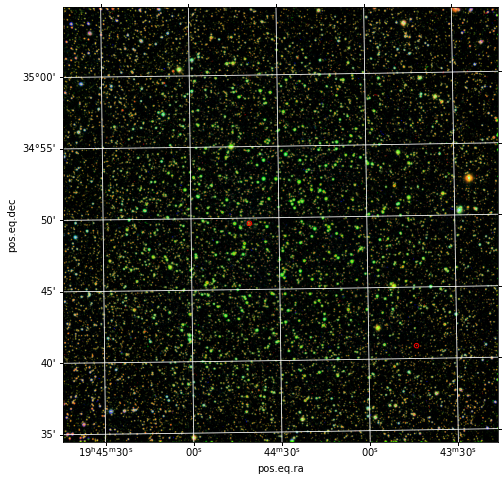

<Figure size 576x576 with 0 Axes>

jid 326016: ( EU Cyg )
4 October 2018 00:59:49 UTC
Filters: ('R', 'V', 'B')
Solving for 4CFF10F6
solve-field -p -l 15 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solver85lwy3rm/tmp9qad85m8.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


KeyboardInterrupt: 

<Figure size 576x576 with 0 Axes>

In [ ]:
figsize(8,8)
for n, j in enumerate(complete):
    jid = int(OSO.get_request(int(j['id']))['jid'][1:])
    print(f'{n}:{jid}', end='\r')
    if jid not in DB:
        process_job(jid)

In [ ]:
1/0

In [ ]:
hud = fits.open(OSO.get_obs(OSO.get_job(333721), cube=True, verbose=False))[0]

In [ ]:
hud = fits.open(OSO.get_obs(OSO.get_job(338617), cube=True, verbose=False))[0]

In [ ]:
z = OSO.get_obs(OSO.get_job(338617), cube=False, verbose=False)
hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]

In [ ]:
solver.solve(hdul[0])

In [ ]:
data = hdul[2].data
imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))

In [ ]:
#local 
now = datetime.fromtimestamp(time.time())
olst = OSO.get_obs_list(t=datetime(now.year, 
                                   now.month, 
                                   now.day-1, 
                                   16, 0).timestamp())
print(f'Observations: {len(olst)}')

In [ ]:
olst

In [ ]:
def solve_field_upload(img, crop=((0,-32),(0,-32)), cache='.cache/wcs', 
                       set_center=True, force_solve=False):
    hdu = fits.open(img.name)[0]
    if hdu.verify_datasum()!=1:
        hdu.add_datasum()
    fn = f'{int(hdu.header["DATASUM"]):08X}.wcs'
    fp = os.path.join(cache,fn[0],fn[1],fn)
    if force_solve or not os.path.isfile(fp) :
        print('Solving for ', fp)
        try :
            settings = {'scale_type': 'ul',
                        'scale_units': 'arcsecperpix',
                        'scale_lower': 0.5,
                        'scale_upper': 2,
                       }
            if set_center :
                settings.update({'center_ra': hdu.header['RA']*15,
                                 'center_dec': hdu.header['DEC'],
                                 'radius': 1, 
                                 'parity': 0,
                                })

            wcs_header = ast.solve_from_image(img.name, force_image_upload=True, solve_timeout=120, **settings)
            if wcs_header :
                print('Success')
                wcs_header['NAXIS'] = 2
                wcs_header['NAXIS1'] = wcs_header['IMAGEW']
                wcs_header['NAXIS2'] = wcs_header['IMAGEH']
                try : 
                    os.makedirs(os.path.dirname(fp), exist_ok=True)
                    with open(fp, 'w') as fh:
                        wcs_header.totextfile(fp)
                except TypeError:
                    pass
            else :
                print('No solution')
        except ASTTimeoutError:
            print('Solver timeout')
            wcs_header=None
    else :
        print(f'Getting {fp} from cache')
        wcs_header=None
        from astropy.io.fits import Header
        with open(fp, 'r') as fh:
            wcs_header = Header.fromtextfile(fh)
    return wcs_header    

In [ ]:
def solve_field_list(hdu, crop=((0,-32),(0,-32)), cache='.cache/wcs', 
                set_center=True, force_solve=False, force_upload=False,
                minsrc=50, maxsrc=500):
    if hdu.verify_datasum()!=1:
        hdu.add_datasum()
    fn = f'{int(hdu.header["DATASUM"]):08X}.wcs'
    fp = os.path.join(cache,fn[0],fn[1],fn)
    if force_solve or not os.path.isfile(fp) :
        print('Solving for ', fp)
        data = hdu.data[crop[0][0]:crop[0][1],crop[1][0]:crop[1][1]]
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        sigma = 200
        for n in range(20) :
            daofind = DAOStarFinder(fwhm=8.0, threshold=sigma*std)
            sources = daofind(data - median)
            #print(sigma, sources)
            if sources is None or len(sources) < minsrc:
                sigma /= 2
            elif len(sources) > maxsrc:
                sigma *= 2
            else :
                break
        else :
            print(f'Cannot extract {minsrc} < n < {maxsrc} sources.')
            return None


        sources.sort('flux')
        sources.reverse()


        try :
            settings = {'scale_type': 'ul',
                        'scale_units': 'arcsecperpix',
                        'scale_lower': 0.5,
                        'scale_upper': 2,
                       }
            if set_center :
                settings.update({'center_ra': hdu.header['RA']*15,
                                 'center_dec': hdu.header['DEC'],
                                 'radius': 1, 
                                 'parity': 0,
                                })

            wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'], 
                                                    data.shape[0], data.shape[1],
                                                    solve_timeout=120,
                                                    **settings)
            if wcs_header :
                print('Success')
                wcs_header['NAXIS'] = 2
                wcs_header['NAXIS1'] = wcs_header['IMAGEW']
                wcs_header['NAXIS2'] = wcs_header['IMAGEH']
                try : 
                    os.makedirs(os.path.dirname(fp), exist_ok=True)
                    with open(fp, 'w') as fh:
                        wcs_header.totextfile(fp)
                except TypeError:
                    pass
            else :
                print('\nNo solution')
        except ASTTimeoutError:
            print('\nSolver timeout')
            wcs_header=None
    else :
        print(f'Getting {fp} from cache')
        wcs_header=None
        from astropy.io.fits import Header
        with open(fp, 'r') as fh:
            wcs_header = Header.fromtextfile(fh)
    return wcs_header

In [ ]:
OSO.get_job(olst[0])

In [ ]:

figsize(8, 8)
for nj, jid in enumerate(olst):
    #jid = int(OSO.get_request(int(rq['id']))['jid'][1:])
    job = OSO.get_job(jid)
    ctime = job['completion']
    print(f'{nj}:jid {jid} (', OSO.get_request(int(job['rid'].split()[0][1:]))['name'], f'):  {" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)    
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')
    if jid in DB :
        print('Done')
        display.clear_output(wait=True);
        continue
    hi = min(1, len(hdul)-1)
    try :
        wcs_head = solve_field_list(hdul[hi])
    except ASTTimeoutError:
        wcs_head = None
#    wcs_head = None
    if not wcs_head:
        try:
            img = OSO.get_obs(job, cube=True, verbose=False)
            wcs_head = solve_field_upload(img)
        except ASTTimeoutError:
            wcs_head = None
    if not wcs_head:
        try :
            wcs_head = solve_field_list(hdul[hi], set_center=False)
        except ASTTimeoutError:
            wcs_head = None
    if not wcs_head:
        try:
            img = OSO.get_obs(job, cube=True, verbose=False)
            wcs_head = solve_field_upload(img, set_center=False)
        except ASTTimeoutError:
            wcs_head = None
    if wcs_head :
        hdul[hi].add_datasum()
        fn = f'{int(hdul[hi].header["DATASUM"]):08X}.wcs'
        fp = os.path.join('.cache/wcs',fn[0],fn[1],fn)
        try : 
            os.makedirs(os.path.dirname(fp), exist_ok=True)
            with open(fp, 'w') as fh:
                wcs_head.totextfile(fp)
        except TypeError:
            pass
    if not wcs_head:
        print('Cannot solve image')
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
        show();
        continue
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
    for g in result:
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'

            #print(f'{name:12} {o["magMax"]:6.2f} {o.keys()}')
#             print(f'{name:12} {o["magMax"]:6.2f}')
    subplot(projection=w)
    grid(color='white', ls='solid')
    ax = gca()
    for g in result:
        #print(g)
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            try : 
                try :
                    radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                                     frame='fk5', unit=(u.hourangle, u.deg))
                except ValueError:
                    radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], 
                                     frame='fk5', unit=(u.deg, u.deg))
            except KeyError:
                    radec =  SkyCoord(o['_RA.icrs'] + o['_DE.icrs'], 
                                     frame='icrs', unit=(u.hourangle, u.deg))
#                     radec =  SkyCoord(o['RAB1950'] + o['DEB1950'], 
#                                      frame='fk4', unit=(u.hourangle, u.deg))
            ax.scatter(radec.ra.deg, radec.dec.deg, transform=ax.get_transform('icrs'), s=20, edgecolor='red', facecolor='none')
#             ax.text(radec.ra.deg, radec.dec.deg, f'  {name} ({o["magMax"]})', 
#                     transform=ax.get_transform('fk5'), color='red')
    display.clear_output(wait=True)
    print(f'{nj}:jid {jid} (', OSO.get_request(int(job['rid'].split()[0][1:]))['name'], f'):  {" ".join(ctime)}')
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')

    try :
        if len(hdul)==3:
            imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul]))
        else :
            data = hdul[hi].data[:-32,:-32]
            imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    except aa.MaxIterError:
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    show()
    display.display(gcf());

In [ ]:
jid = 383576
img = OSO.get_obs(OSO.get_job(jid), cube=True, verbose=True)
solve_field_upload(img);

In [ ]:
rq = complete[0]
jid = int(OSO.get_request(int(rq['id']))['jid'][1:])

In [ ]:
jid = 383310
img = OSO.get_obs(OSO.get_job(jid), cube=True, verbose=True)
z = OSO.get_obs(OSO.get_job(jid), cube=False, verbose=True)

In [ ]:
solve_field_upload(img)

In [ ]:
hdul = fits.open(img.name)[0]

In [ ]:
hdul.fileinfo()

In [ ]:
hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]

In [ ]:
hdu = hdul[1]
for n, hdu in enumerate(hdul):
    print(n, hdu.header['FILTER'])

In [ ]:
w = solve_field(hdu)

In [ ]:
r, g, b = (hdu.data[:-32,:-32] for hdu in hdul)

In [ ]:
subplot(projection=WCS(w))
imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul],
                        black=1.15,
                        stretch=100,
                        Q=5
                       ))
grid(color='white', ls='solid')

In [ ]:
imshow(g, norm=simple_norm(g, 'asinh', asinh_a=0.1))

In [ ]:
f'{int(hdu.header["DATASUM"]):08X}'

In [ ]:
aa.register(b, g, detection_sigma=10)

In [ ]:
data = hdu.data[:-32,:-32]
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
norm=simple_norm(data, 'asinh', asinh_a=0.001)
daofind = DAOStarFinder(fwhm=4.0, threshold=200.*std)
sources = daofind(data - median)
sources.sort('flux')
sources.reverse()
len(sources)

In [ ]:
figsize(10,10)
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.)
imshow(data, cmap='gray', norm=norm, interpolation='nearest')
apertures.plot(color='yellow', lw=1.5, alpha=0.5);

In [ ]:
wcs_header['NAXIS']=2
wcs = WCS(wcs_header)
box = wcs.calc_footprint(wcs_header, axes=data.shape)
c = box.mean(axis=0)
s = box.max(axis=0) - box.min(axis=0)

In [ ]:
#cats = list(Vizier.find_catalogs('gcvs')) + list(Vizier.find_catalogs('vsx'))
cats = ['B/gcvs', 'B/vsx']
cats = 'B/gcvs'

In [ ]:
result = Vizier.query_region(catalog=cats, coordinates=SkyCoord(*c, unit='deg', frame='fk5'), width=f'{s[0]}deg', height=f'{s[1]}deg')
for g in result:
    for n, o in enumerate(g):
        if 'Name' in o.keys():
            name = o['Name']
        elif 'GCVS' in o.keys():
            name = ' '.join(o['GCVS'].split())
        elif 'NSV' in o.keys():
            name = f'NSV_{o["NSV"]}'

        print(f'{name:12} {o["magMax"]:6.2f}')

In [ ]:
figsize(14,14)
subplot(projection=wcs)
imshow(data, norm=norm)
grid(color='white', ls='solid')
ax = gca()
for g in result:
    for n, o in enumerate(g):
        if 'Name' in o.keys():
            name = o['Name']
        elif 'GCVS' in o.keys():
            name = ' '.join(o['GCVS'].split())
        elif 'NSV' in o.keys():
            name = f'NSV_{o["NSV"]}'
        else :
            name = f'VS_{n}'
        try :
            radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], frame='fk5', unit=(u.hourangle, u.deg))
        except ValueError:
            radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
        ax.scatter(radec.ra.deg, radec.dec.deg, transform=ax.get_transform('icrs'), s=20, edgecolor='red', facecolor='none')
        ax.text(radec.ra.deg, radec.dec.deg, f'  {name} ({o["magMax"]:.1f})', 
                transform=ax.get_transform('fk5'), color='red')
    

In [ ]:
figsize(10,10)
imshow((data),aspect='equal', norm=simple_norm(data, 'asinh', asinh_a=0.0005))

In [ ]:
#subplot(projection=wcs)
imshow(make_color_image([hdu.data[:-100,:-100] for hdu in hdul]))
#grid(color='white', ls='solid')

In [ ]:
def searchVS(h, cat='GCVS', caturl=None, maxSearchRadius=5):
    '''
    Search the area of the image in h (hdu, fits) for variable stars
    using the given catalogue. The cat imput parameter denotes the 
    catalogue:
    
    'GCVS' - use the General Catalogue of Variable Stars
    'VSX'  - use the AAVSO Variable Star Index
    'USER' - use the custom url passed in caturl parameter
    
    The maximum search radius is specified by maxSearchRadius (deg).
    
    Returns a list of VS in the circle with the frame inscribed in it.
    '''
    from pyvo import conesearch
    
    if cat=='GCVS' :
        caturl='http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=B/vsx&amp;'
    elif cat=='VSX' :
        caturl='http://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl?table=aavsovsx&amp;'
    else :
        caturl=caturl
    
    w=WCS(h)
    cen=w.all_pix2world(array([[h['NAXIS1'], h['NAXIS2']]])/2,0)[0]
    # Half of the hypotenuse of the frame = radius of the search
    rad=sqrt(sum((real(eigvals(w.wcs.cd))*array([h['NAXIS1'], h['NAXIS2']]))**2))/2
    # Clamp to reasonable size
    rad=min(rad, maxSearchRadius)
    r=conesearch(caturl,pos=list(cen),radius=rad)
    return r

In [ ]:
searchVS(wcs_header)

In [ ]:
wcs_header['NAXIS1']=wcs_header['IMAGEW']
wcs_header['NAXIS2']=wcs_header['IMAGEH']

In [ ]:
def analyseJob(scope, jid, cat='GCVS'):
    obs=scope.get_job(jid)
    if obs['type']!='SSBODY' :
        print jid, obs['filter'], obs['exp'], obs['type'], obs['oid']
        
        z=scope.get_obs(obs,cube=False)
        
        hdul=[fits.open(BytesIO(z.read(name))) for name in z.namelist()]

        for h,f in zip(hdul,obs['filter']):
            h[0].header['FILTER']=f

        shdul=[scope.solveField(h[0],name=str(jid)) for h in hdul]
        for n,h in enumerate(shdul):
            print 'Filter: ',hdul[n][0].header['FILTER'],
            if h is None :
                print 'Unable to solve the field!'
                imshow(sqrt(hdul[n][0].data),aspect='equal')
                continue
            w=wcs.WCS(h[0].header)
            imshow(sqrt(h[0].data),aspect='equal')
            plot(h[0].header['NAXIS1']/2,h[0].header['NAXIS2']/2,'r+',ms=30)
            if obs['type']=='RADEC':
                obj=SkyCoord(obs['oid'], unit=(u.hourangle, u.deg))
            else :
                obj=SkyCoord.from_name(obs['type']+obs['oid'])
            pix=w.all_world2pix(array([[obj.ra.deg,obj.dec.deg]]),0)[0]
            plot(pix[0],pix[1],'r+',ms=20)
            plot(pix[0],pix[1],'ro',fillstyle='none', ms=12)
            r=searchVS(h)
            print "Number of VS:", len(r)
            for s in r:
                vsname='%(Name)-25s' % s
                # filter out NSV and VSX hits (leave just GCVS marked stars)
                if vsname.find('NSV')<0 and vsname.find('VSX')<0 :
                    pix=w.all_world2pix(array([[s.ra,s.dec]]),0)[0]
                    # reject out of frame stars
                    if 0 < pix[0] < h[0].header['NAXIS1'] and 0 < pix[1] < h[0].header['NAXIS2'] :
                        plot(pix[0],pix[1],'ro',fillstyle='none')
                        annotate(vsname, pix, xytext=(5,-7), textcoords='offset points', color='y')
                        print '%(Name)25s %(Period)12.6f %(min)6.2f - %(max)6.2f ' % s
            xlim(0,h[0].header['NAXIS1'])
            ylim(0,h[0].header['NAXIS2'])
            show()
        print
    